# Notebook for different Activation Functions and Initialization Methods

# Packages

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm.notebook import tqdm
import seaborn as sns
import imageio
import time
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

In [5]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(" ", ["red", "yellow", "green"])

In [6]:
np.random.seed(0)

# Generate Data

In [7]:
data, labels = make_blobs(n_samples = 500, n_features = 2, centers = 4, random_state = 0)
print(data.shape, labels. shape)

(500, 2) (500,)


[]

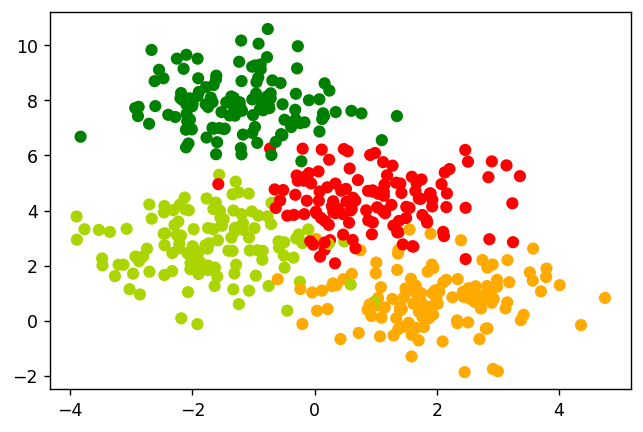

In [8]:
plt.figure(figsize = (6, 4), dpi = 125)
plt.scatter(data[:, 0], data[:, 1], c = labels, cmap = cmap)
plt.plot()

# Multiclass Classification

In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify = labels, random_state = 0)
print(X_train.shape, Y_train.shape, X_val.shape)

(375, 2) (375,) (125, 2)


In [10]:
enc = OneHotEncoder()
Y_OH_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
Y_OH_val = enc.fit_transform(np.expand_dims(Y_val, 1)).toarray()

# FeedForward Network

In [11]:
class network:
    def __init__(self, init_method = 'random', activation_function = 'sigmoid', leaky_slope = 0.1):

        self.params = {}
        self.params_h = []
        self.gradients = {}
        self.num_layers = 2
        self.layer_sizes = [2, 2, 4]

        np.random.seed(0)

        if init_method == 'zeros':
            for i in range(1, self.num_layers + 1):
                self.params["W"+str(i)] = np.zeros((self.layer_sizes[i - 1], self.layer_sizes[i]))
                self.params["B"+str(i)] = np.zeros((1, self.layer_sizes[i]))
        
        if init_method == 'random':
            for i in range(1, self.num_layers + 1):
                self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i - 1], self.layer_sizes[i])
                self.params["B"+str(i)] = np.random.randn(1, self.layer_sizes[i])
        
        if init_method == 'xavier':
            for i in range(1, self.num_layers + 1):
                self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i - 1], self.layer_sizes[i]) * np.sqrt(1/self.layer_sizes[i - 1])
                self.params["B"+str(i)] = np.random.randn(1, self.layer_sizes[i])
        
        if init_method == 'he':
            for i in range(1, self.num_layers + 1):
                self.params["W"+str(i)] = np.random.randn(self.layer_sizes[i - 1], self.layer_sizes[i]) * np.sqrt(2/self.layer_sizes[i - 1])
                self.params["B"+str(i)] = np.random.randn(1, self.layer_sizes[i])

        
        self.activation_function = activation_function
        self.leaky_slope = leaky_slope

        self.update_params = {}
        self.prev_update_params = {}

        for i in range(1, self.num_layers + 1):
            self.update_params["v_w"+str(i)] = 0
            self.update_params["v_b"+str(i)] = 0
            self.update_params["m_w"+str(i)] = 0
            self.update_params["m_b"+str(i)] = 0
            self.prev_update_params["v_w"+str(i)] = 0
            self.prev_update_params["v_b"+str(i)] = 0
    
    def forward_activation(self, X):
        if self.activation_function == 'sigmoid':
            return 1.0 / (1.0 + np.exp(-X))
        elif self.activation_function == 'tanh':
            return np.tanh(X)
        elif self.activation_function == 'relu':
            return np.maximum(0, X)
        elif self.activation_function == 'leaky_relu':
            return np.maximum(self.leaky_slope * X, X)
    
    def grad_activation(self, X):
        if self.activation_function == 'sigmoid':
            return X * (1 - X)
        elif self.activation_function == 'tanh':
            return (1 - np.square(X))
        elif self.activation_function == 'relu':
            return 1.0 * (X > 0)
        elif self.activation_function == 'leaky_relu':
            d = np.zeros_like(X)
            d[X <= 0] = self.leaky_slope
            d[X > 0] = 1
            return d
    
    def softmax(self, X):
        exps = np.exp(X)
        return exps / np.sum(exps, axis = 1).reshape(-1, 1)
    
    def forwardPass(self, X, params = None):
        if params is None: params = self.params

        self.A1 = np.matmul(X, params["W1"]) + params["B1"]            # (N, 2) * (2, 2) -> (N, 2)
        self.H1 = self.forward_activation(self.A1)                     # (N, 2)
        self.A2 = np.matmul(self.H1, params["W2"]) + params["B2"]      # (N, 2) * (2, 4) -> (N, 4)
        self.H2 = self.softmax(self.A2)                                          # (N, 4)
        return self.H2                                                           # (N, 4)
    
    def backpropagation(self, X, Y, params = None):
        if params is None: params = self.params

        m = X.shape[0]
        self.forwardPass(X, params)

        self.gradients["dA2"] = self.H2 - Y                                                       # (N, 4)
        self.gradients["dW2"] = np.matmul(self.H1.T, self.gradients["dA2"])                       # (2, N) * (N, 4) -> (2, 4)
        self.gradients["dB2"] = np.sum(self.gradients["dA2"], axis = 0).reshape(1, -1)            # (N, 4) -> (1, 4)
        self.gradients["dH1"] = np.matmul(self.gradients["dA2"], params["W2"].T)                  # (N, 4) * (4, 2) -> (N, 2)
        self.gradients["dA1"] = np.multiply(self.gradients["dH1"], self.grad_activation(self.H1)) # (N, 2) .* (N, 2) -> (N, 2)
        self.gradients["dW1"] = np.matmul(X.T, self.gradients["dA1"])                             # (2, N) * (N, 4) -> (2, 4)
        self.gradients["dB1"] = np.sum(self.gradients["dA1"], axis = 0).reshape(1, -1)            # (N, 2) -> (1, 2)
    
    def fit(self, X, Y, algo = 'GD', epochs = 1, eta = 1.0, display_loss = True, 
            minibatch_size = 128, gamma = 0.9, eps = 1e-8, beta = 0.9, beta1 = 0.9,
            beta2 = 0.9):
        if display_loss:
            loss = {}
        
        m = X.shape[0]
        for e in tqdm(range(epochs), total = epochs, unit = "epoch"):
            if algo == 'GD':
                self.backpropagation(X, Y)
                for i in range(1, self.num_layers + 1):
                    self.params["W"+str(i)] -= (eta * (self.gradients["dW"+str(i)] / m))
                    self.params["B"+str(i)] -= (eta * (self.gradients["dB"+str(i)] / m))
            
            if display_loss:
                Y_pred = self.predict(X)
                loss[e] = log_loss(Y, Y_pred)
                self.params_h.append(np.concatenate((self.params["W1"].ravel(), self.params["W2"].ravel(), self.params["B1"].ravel(), self.params["B2"].ravel())))
        
        if display_loss:
            plt.figure(figsize = (6, 4), dpi = 125)
            plt.plot(list(loss.values()), '-o', markersize = 3)
            plt.xlabel('Epochs')
            plt.ylabel('Log Loss')
            plt.show()
    
    def predict(self, X):
        Y_pred = self.forwardPass(X)
        return np.array(Y_pred).squeeze()

In [12]:
def post_process(scatter_plot=False, gradient_plot=True, plot_scale=0.1):    
    Y_pred_train = model.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train,1)
    Y_pred_val = model.predict(X_val)
    Y_pred_val = np.argmax(Y_pred_val,1)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)
    accuracy_val = accuracy_score(Y_pred_val, Y_val)
    print("Training accuracy", round(accuracy_train, 4))
    print("Validation accuracy", round(accuracy_val, 4))    
    
    if scatter_plot:
      plt.scatter(X_train[:,0], X_train[:,1], c=Y_pred_train, cmap=my_cmap, s=15*(np.abs(np.sign(Y_pred_train-Y_train))+.1))
      plt.show()
      
    if gradient_plot:
      h = np.asarray(model.params_h)
      h_diff = (h[0:-1, :] - h[1:, :])
      for i in range(18):
        plt.subplot(6, 3, i+1)
        plt.plot(h_diff[:, i], '-')
        plt.ylim((-plot_scale, plot_scale))
        plt.yticks([])
        plt.xticks([])
      plt.figure(figsize = (6, 4), dpi = 125)
      plt.show()

  0%|          | 0/10 [00:00<?, ?epoch/s]

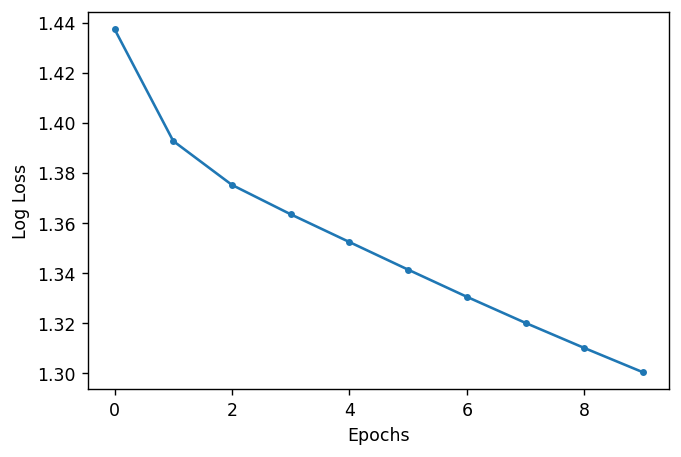

Training accuracy 0.3973
Validation accuracy 0.408


In [13]:
model = network(init_method='xavier', activation_function='sigmoid')
model.fit(X_train, Y_OH_train, epochs=10, eta=1, algo="GD", display_loss=True)
post_process(gradient_plot = False)

zeros sigmoid


  0%|          | 0/10 [00:00<?, ?epoch/s]

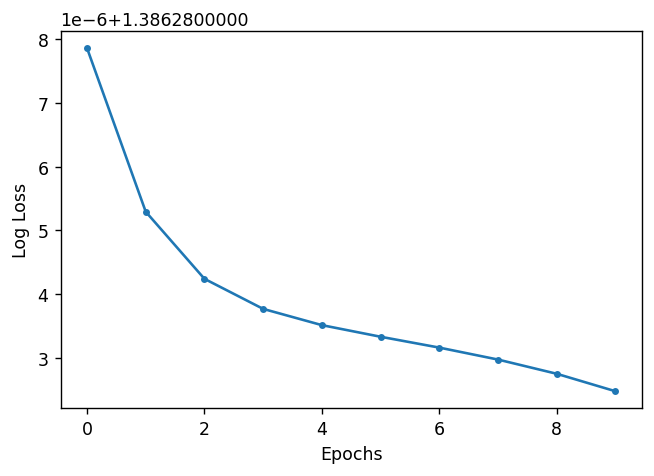

Training accuracy 0.2507
Validation accuracy 0.248

--

random sigmoid


  0%|          | 0/10 [00:00<?, ?epoch/s]

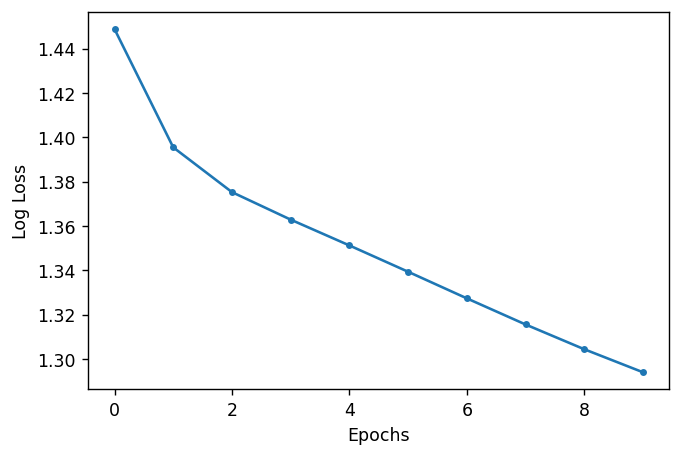

Training accuracy 0.3867
Validation accuracy 0.384

--

xavier sigmoid


  0%|          | 0/10 [00:00<?, ?epoch/s]

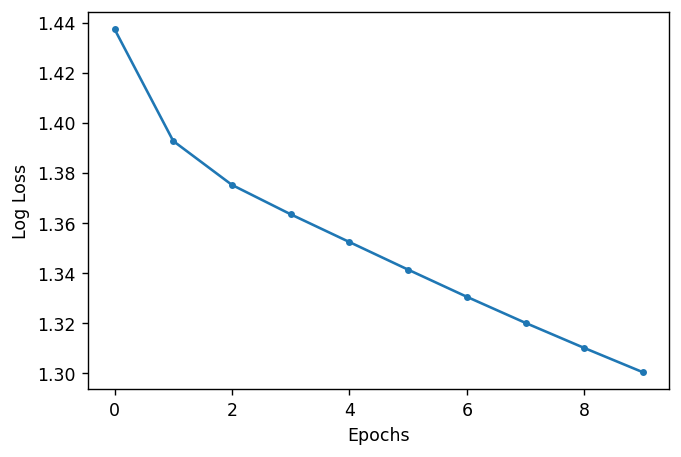

Training accuracy 0.3973
Validation accuracy 0.408

--

he sigmoid


  0%|          | 0/10 [00:00<?, ?epoch/s]

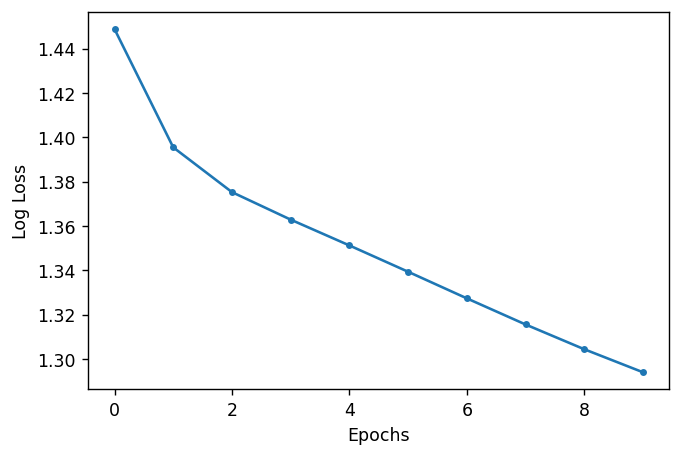

Training accuracy 0.3867
Validation accuracy 0.384

--



In [14]:
for init_method in ['zeros', 'random', 'xavier', 'he']:
  for activation_function in ['sigmoid']:
    print(init_method, activation_function)
    model = network(init_method=init_method, activation_function=activation_function)
    model.fit(X_train, Y_OH_train, epochs=10, eta=1, algo="GD", display_loss=True)
    post_process(plot_scale=0.05, gradient_plot = False)
    print('\n--\n')

zeros tanh


  0%|          | 0/100 [00:00<?, ?epoch/s]

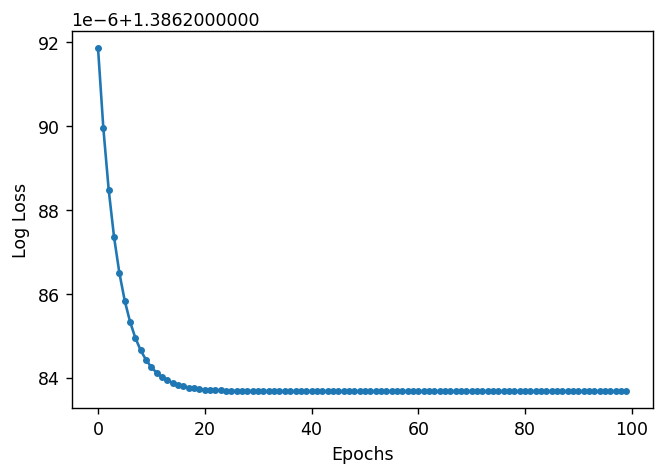

Training accuracy 0.2507
Validation accuracy 0.248

--

random tanh


  0%|          | 0/100 [00:00<?, ?epoch/s]

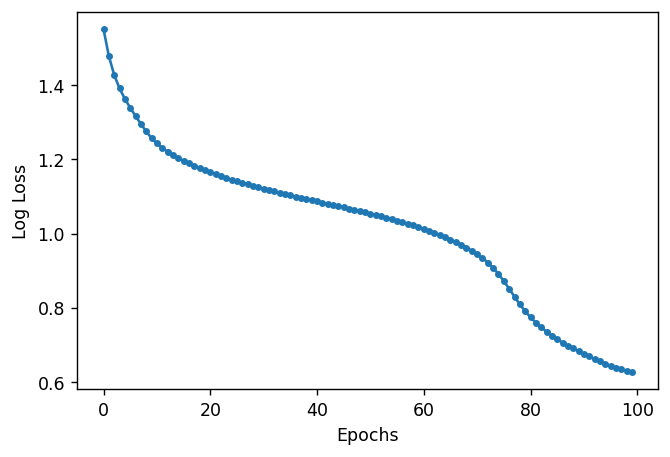

Training accuracy 0.7307
Validation accuracy 0.744

--

xavier tanh


  0%|          | 0/100 [00:00<?, ?epoch/s]

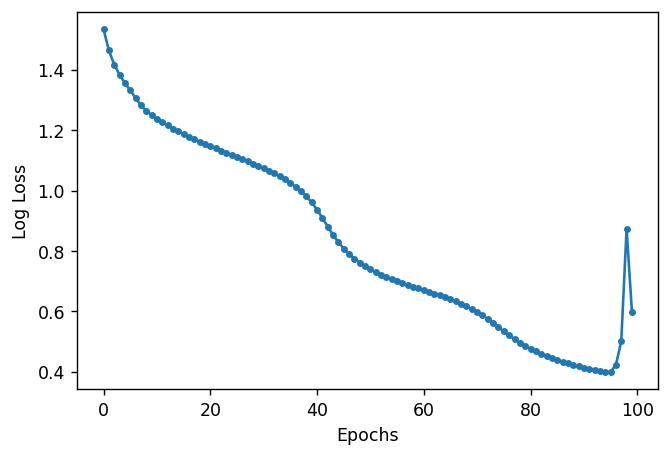

Training accuracy 0.744
Validation accuracy 0.72

--

he tanh


  0%|          | 0/100 [00:00<?, ?epoch/s]

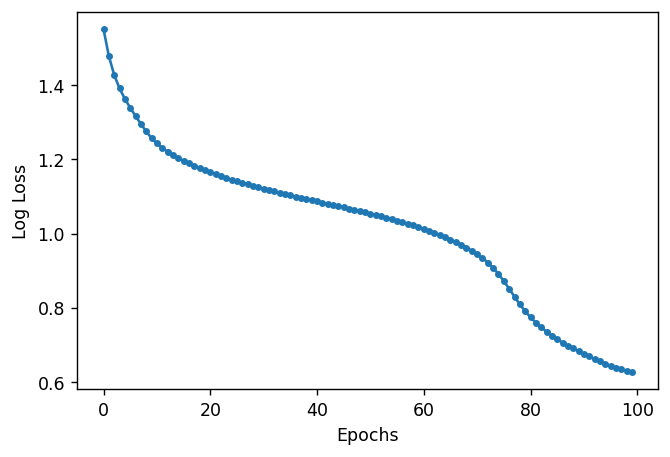

Training accuracy 0.7307
Validation accuracy 0.744

--



In [15]:
for init_method in ['zeros', 'random', 'xavier', 'he']:
  for activation_function in ['tanh']:
    print(init_method, activation_function)
    model = network(init_method=init_method, activation_function=activation_function)
    model.fit(X_train, Y_OH_train, epochs=100, eta=0.5, algo="GD", display_loss=True)
    post_process(plot_scale=0.05, gradient_plot = False)
    print('\n--\n')

zeros relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

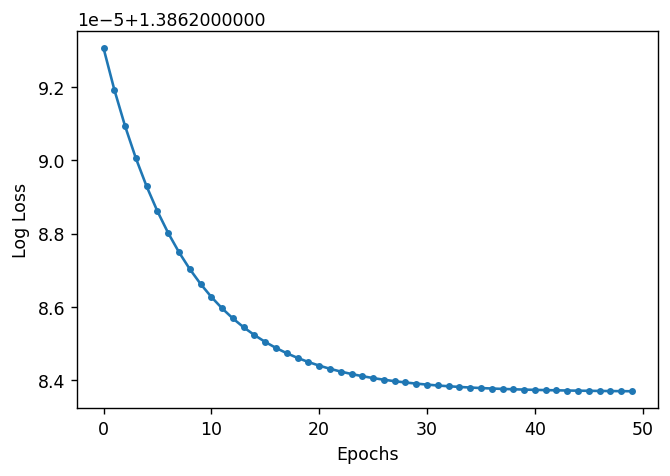

Training accuracy 0.2507
Validation accuracy 0.248

--

random relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

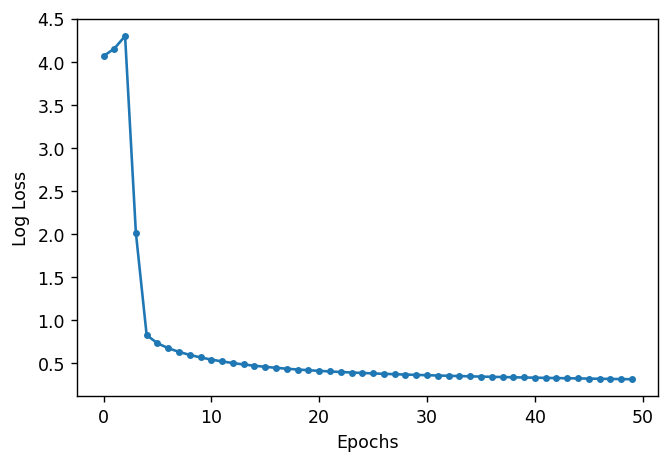

Training accuracy 0.9307
Validation accuracy 0.912

--

xavier relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

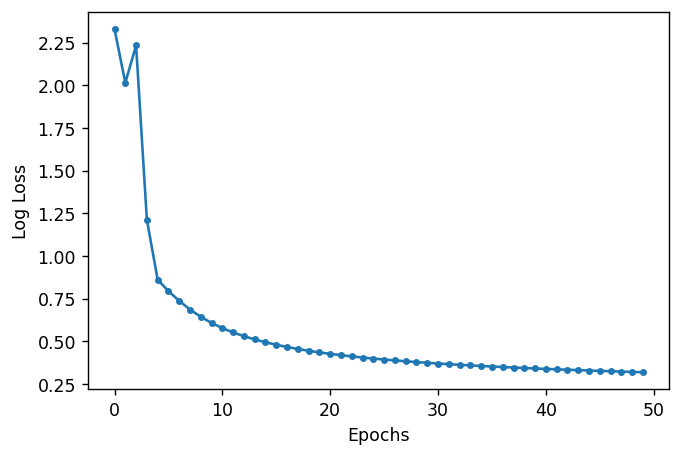

Training accuracy 0.9307
Validation accuracy 0.904

--

he relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

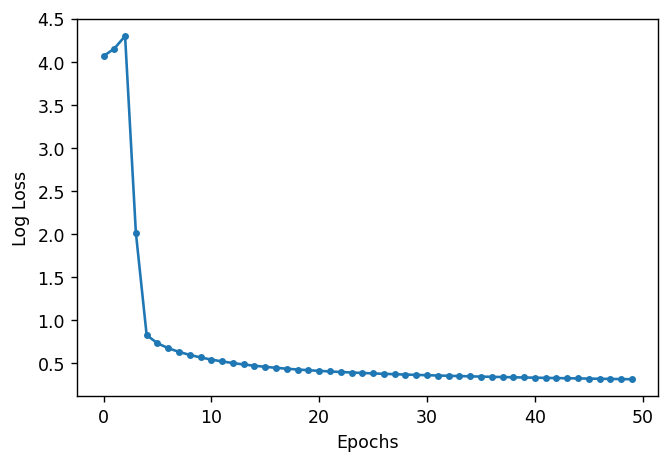

Training accuracy 0.9307
Validation accuracy 0.912

--



In [16]:
for init_method in ['zeros', 'random', 'xavier', 'he']:
  for activation_function in ['relu']:
    print(init_method, activation_function)
    model = network(init_method=init_method, activation_function=activation_function)
    model.fit(X_train, Y_OH_train, epochs=50, eta=.25, algo="GD", display_loss=True)
    post_process(plot_scale=0.05, gradient_plot = False)
    print('\n--\n')

zeros leaky_relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

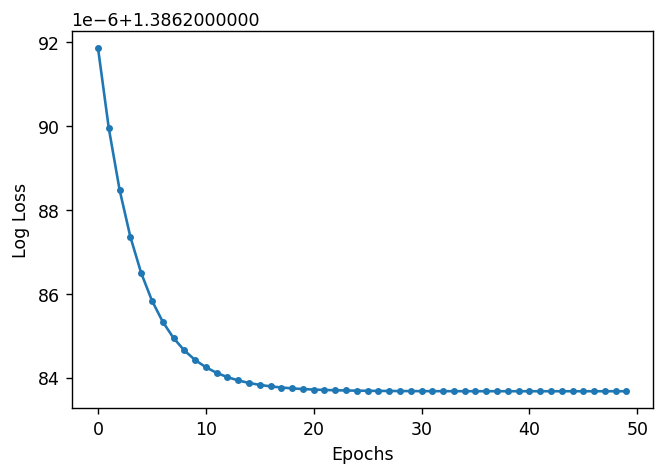

Training accuracy 0.2507
Validation accuracy 0.248

--

random leaky_relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

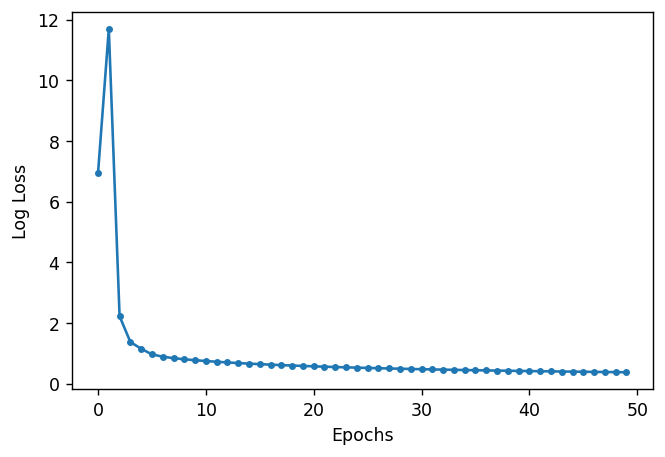

Training accuracy 0.912
Validation accuracy 0.888

--

xavier leaky_relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

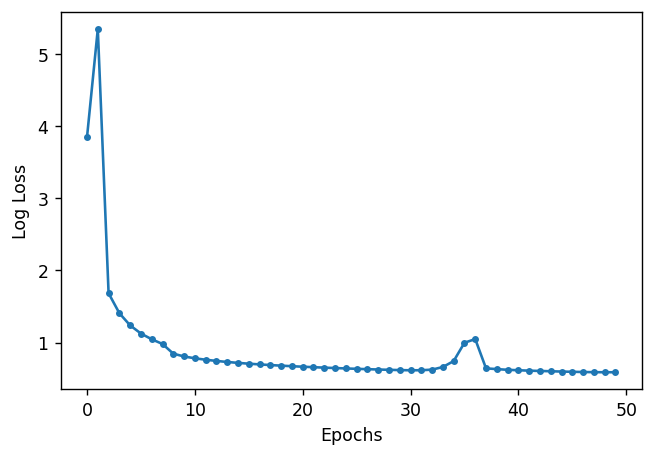

Training accuracy 0.7147
Validation accuracy 0.704

--

he leaky_relu


  0%|          | 0/50 [00:00<?, ?epoch/s]

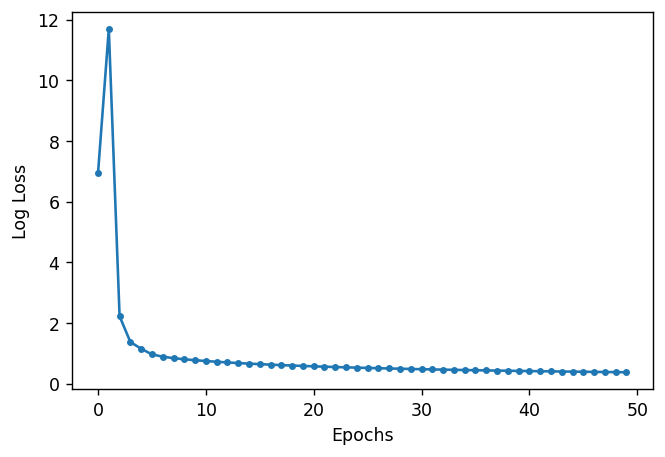

Training accuracy 0.912
Validation accuracy 0.888

--



In [17]:
for init_method in ['zeros', 'random', 'xavier', 'he']:
  for activation_function in ['leaky_relu']:
    print(init_method, activation_function)
    model = network(init_method=init_method, activation_function=activation_function)
    model.fit(X_train, Y_OH_train, epochs=50, eta=0.5, algo="GD", display_loss=True)
    post_process(plot_scale=0.05, gradient_plot = False)
    print('\n--\n')